In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
ladf = pd.read_csv('data/ladf.csv')

In [3]:
layr = ladf.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)

In [4]:
# X = ladf.drop(['Year', 'Month', 'zipcode'], axis=1).values
# scaler = MinMaxScaler()
# X_sca = scaler.fit_transform(X)
# model = KMeans(5, n_init=3)
# model.fit(X_sca)
# labels = model.labels_
# centroids = model.cluster_centers_ 
# # ladf['class'] = labels
# cntClass = ladf.groupby(['Year', 'Month', 'class'])['zipcode'].count().unstack().reset_index()
# for cent in centroids:
#     print cent

In [5]:
# X_test = cntClass.drop(['Year', 'Month'], axis=1).values

In [6]:
# X_test = 1.0 * X_test / X_test.sum(axis =1).reshape(-1, 1)

In [7]:
# plt.figure()
# for k in xrange(5):
#     plt.plot(X_test[:,k], label= k)
# plt.legend(loc='best')
# plt.show()

In [8]:
ladf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26954 entries, 0 to 26953
Data columns (total 13 columns):
Year       26954 non-null int64
Month      26954 non-null int64
zipcode    26954 non-null int64
1          26954 non-null float64
2          26954 non-null float64
3          26954 non-null float64
4          26954 non-null float64
5          26954 non-null float64
6          26954 non-null float64
7          26954 non-null float64
8          26954 non-null float64
9          26954 non-null float64
10         26954 non-null float64
dtypes: float64(10), int64(3)
memory usage: 2.7 MB


In [9]:
def nmf_test(df, scale=True):
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
    if scale:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    scores = []
    dists = []
    for k in xrange(2, 11):
        model = NMF(n_components=k)
        W = model.fit_transform(X)
        labels = W.argmax(axis=1)
        H = model.components_
        dist = cdist(X, H)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 11), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 11), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()


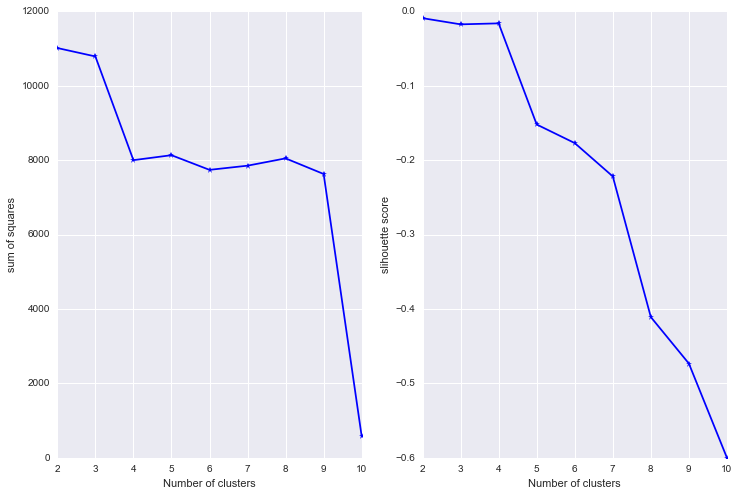

In [10]:
nmf_test(ladf)

In [11]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary', 8: 'Homicide', 9: 'Sex Crime', 10: 'DUI'}

def nmf_pipline(df, k=5):
    numPost = df['zipcode'].unique().shape[0]
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=k)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    new_df['class'] = labels
    cntClass = new_df.groupby(['Year', 'class'])['zipcode'].count().unstack().reset_index()
    X_class = cntClass.drop(['Year'], axis=1).values
    X_class = 1.0 * X_class/ numPost
    years = sorted(df['Year'].unique())
    className = ['cls -{}'.format(k+1) for k in xrange(k)]
    plot_heatmap(H.T, className, k)
    plot_lines(X_class, years, className)
    plot_bars(X_class, years, className)
    plot_corr_mat(X_class, className)
    plt.show()
    droplst = [str(x) for x in range(1, 11)]
    new_df = new_df.drop(droplst, axis=1)
    new_df = pd.concat((new_df, pd.DataFrame(W)), axis=1)
    return model, new_df

def plot_bars(data, years, className):    
    pd.DataFrame(data, columns=className).plot.bar(stacked=True)
    plt.xticks(range(len(years)), years)

def plot_lines(data, years, className):
    n = data.shape[1]
    plt.figure()
    for k in xrange(n):
        plt.plot(years, data[:,k], label=className[k])
    plt.legend(loc='best')
    
def plot_heatmap(data, className, k=5):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(k)+0.5, minor=False, )
    ax.set_yticks(np.arange(10)+0.5, minor=False)
    ax.set_xticklabels(className, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def plot_corr_mat(data, className):
    # Compute the correlation matrix
    corr = pd.DataFrame(data).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots()

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3,
                square=True, xticklabels=className, yticklabels=className,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

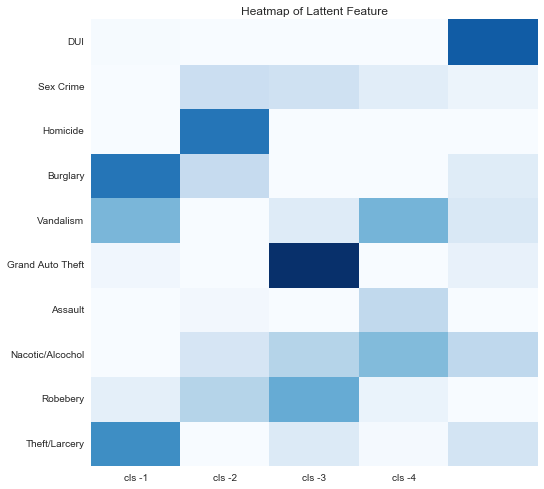

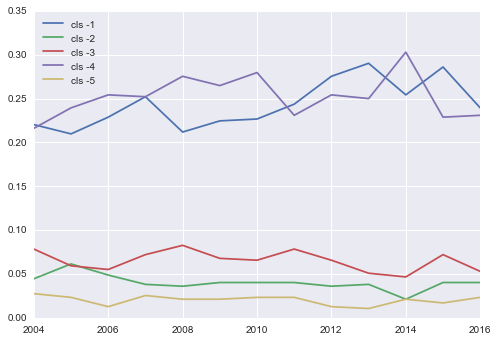

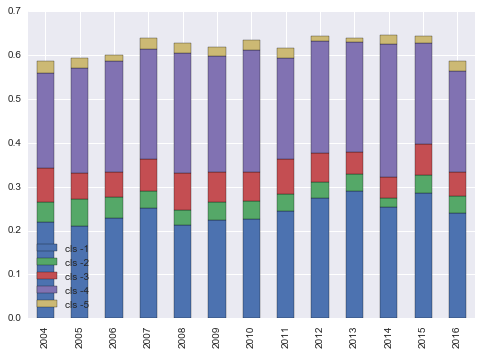

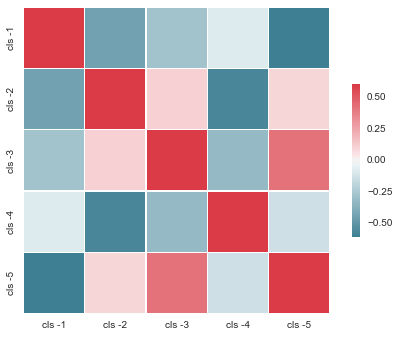

In [12]:
lanmf, la_newdf = nmf_pipline(ladf)

In [13]:
la_newdf.head()

,Year,zipcode,class,0,1,2,3,4
0,2004,90000,2,0.000288,0.000056,0.000631,0.000313,0.000000
1,2004,90001,1,0.024339,0.118815,0.038901,0.000000,0.000237
2,2004,90002,1,0.001161,0.038934,0.005733,0.000000,0.000000
3,2004,90003,1,0.000559,0.000623,0.000264,0.000206,0.000000
4,2004,90004,3,0.000358,0.000000,0.000000,0.002240,0.000000


In [14]:
la_newdf[la_newdf['zipcode'] == 90703]

,Year,zipcode,class,0,1,2,3,4
130,2004,90703,0,0.267206,0.000000,0.084383,0.016416,0.037923
402,2005,90703,0,0.197242,0.017534,0.052831,0.000000,0.063702
686,2006,90703,0,0.138987,0.045844,0.066274,0.000000,0.045058
980,2007,90703,0,0.146071,0.000000,0.039517,0.017294,0.027075
1275,2008,90703,0,0.141206,0.013478,0.031878,0.000000,0.010716
1568,2009,90703,0,0.143210,0.009816,0.022166,0.009563,0.015797
1868,2010,90703,0,0.145850,0.002277,0.029898,0.000000,0.005923
2165,2011,90703,0,0.193380,0.002843,0.031871,0.000000,0.016506
2459,2012,90703,0,0.173062,0.013588,0.014422,0.000000,0.010668
2763,2013,90703,0,0.206246,0.000000,0.029211,0.000000,0.053891


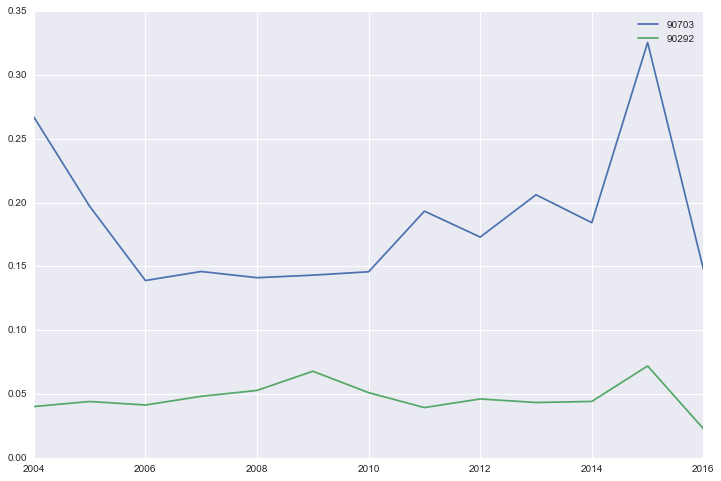

In [60]:
CrimePatterns = {0: 'Stealing Things', 1: 'Life Threatening',
                 2: 'GTA/Robbery', 3: 'Drug Related',
                 4: 'Drunk Driver', 5: 'Unspecify'}

def plot_one_zipcode(df, zipcode):
    y = df[df['zipcode'] == zipcode]['class']
    x = df[df['zipcode'] == zipcode]['Year']
    plt.plot(x, y, 'o-', label=zipcode)

def plot_zipcodes(df, ziplst):
    plt.figure(figsize=(12,8))
    for zipcode in ziplst:
        plot_one_zipcode(df, zipcode)
    plt.yticks(range(5), CrimePatterns.values())
    plt.ylim(-0.5, 4.5)
    plt.legend()
    plt.show()

def plot_one_intensity(df, zipcode):
    x = df[df['zipcode'] == zipcode]['Year']
    y = df[df['zipcode'] == zipcode][[0,1,2,3,4]].max(axis=1)
    plt.plot(x, y, label=zipcode)


def plot_all_inten(df, ziplst):
    plt.figure(figsize=(12,8))
    for zipcode in ziplst:
        plot_one_intensity(df, zipcode)
    plt.legend()
    plt.show()
plot_all_inten(la_newdf, [90703, 90292])

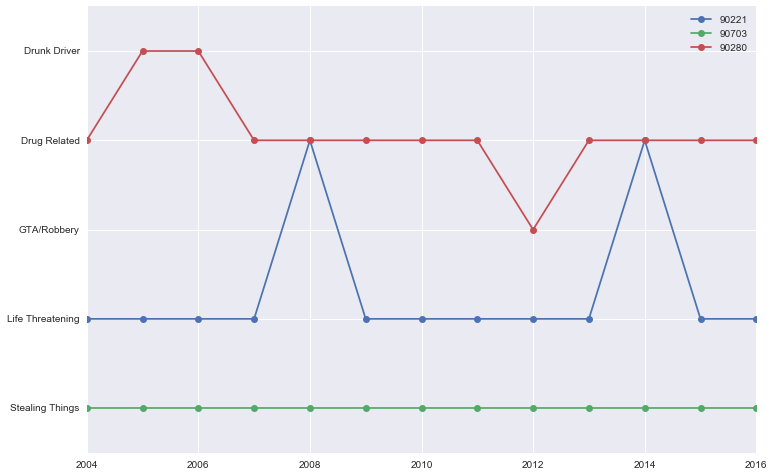

In [16]:
ziplst = [90221, 90703, 90280]
plot_zipcodes(la_newdf, ziplst)

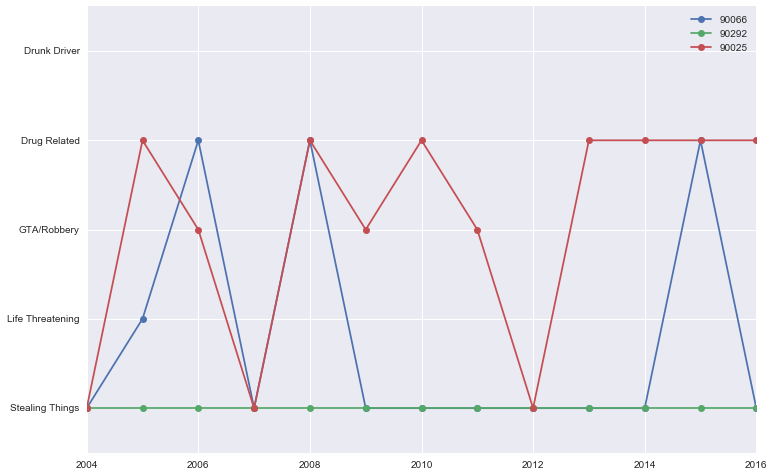

In [17]:
ziplst1 = [90066, 90292, 90025]
plot_zipcodes(la_newdf, ziplst1)

In [52]:
 la_newdf[[1,2,3]].max(axis=1)

0       6.308253e-04
1       1.188153e-01
2       3.893450e-02
3       6.234814e-04
4       2.239708e-03
5       5.027659e-04
6       7.808087e-04
7       2.358522e-02
8       1.285684e-03
9       2.445631e-04
10      1.942726e-03
11      1.859824e-01
12      3.503550e-03
13      5.264916e-04
14      5.381128e-03
15      2.398145e-04
16      6.101000e-03
17      1.184764e-03
18      3.625434e-04
19      1.992951e-03
20      2.387198e-01
21      3.906962e-02
22      8.749750e-05
23      5.323422e-05
24      7.851735e-03
25      3.625434e-04
26      1.698132e-02
27      8.255420e-04
28      1.029525e-03
29      1.912479e-03
            ...     
3783    3.971545e-04
3784    4.517378e-02
3785    4.253101e-02
3786    1.774020e-02
3787    2.701662e-03
3788    2.462346e-02
3789    2.483124e-02
3790    1.257993e-03
3791    2.602696e-04
3792    3.262281e-03
3793    9.344443e-04
3794    2.602696e-04
3795    8.749750e-05
3796    5.205391e-04
3797    3.199241e-04
3798    4.421483e-07
3799    3.011

In [49]:
W

,0,1,2,3,4
0,0.000288,0.000056,6.308253e-04,0.000313,0.000000
1,0.024339,0.118815,3.890091e-02,0.000000,0.000237
2,0.001161,0.038934,5.733437e-03,0.000000,0.000000
3,0.000559,0.000623,2.641162e-04,0.000206,0.000000
4,0.000358,0.000000,0.000000e+00,0.002240,0.000000
5,0.000076,0.000315,3.798399e-04,0.000503,0.000032
6,0.000000,0.000061,4.368095e-05,0.000781,0.000117
7,0.006717,0.000000,0.000000e+00,0.023585,0.000000
8,0.003027,0.001286,1.182106e-03,0.000000,0.000000
9,0.000000,0.000245,7.864907e-05,0.000112,0.000000


In [18]:
phdf = pd.read_csv('data/phdf.csv')
sfdf = pd.read_csv('data/sfdf.csv')
louisdf = pd.read_csv('data/louisdf.csv')
dedf = pd.read_csv('data/dedf.csv')
ladf = pd.read_csv('data/ladf.csv')

In [19]:
sfdf['8'] = 0.0
sfdf = sfdf[['Year', 'Month', 'zipcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

In [20]:
def get_year_data(df):
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    new_df = get_scaled(new_df)
    return new_df

def get_scaled(df):
    cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    X = df[cols].values
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    df[cols] = X_sca
    return df

In [21]:
frames = [ladf, sfdf, phdf, louisdf, dedf]
for idx, df in enumerate(frames):
    frames[idx] = get_year_data(df)

In [22]:
totdf = pd.concat(frames)

In [23]:
totdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6065 entries, 0 to 582
Data columns (total 12 columns):
Year       6065 non-null int64
zipcode    6065 non-null object
1          6065 non-null float64
2          6065 non-null float64
3          6065 non-null float64
4          6065 non-null float64
5          6065 non-null float64
6          6065 non-null float64
7          6065 non-null float64
8          6065 non-null float64
9          6065 non-null float64
10         6065 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 616.0+ KB


In [24]:
# nmf_test(totdf, scale=False)

In [25]:
def nmf_model(df, k=5):
    numPost = df['zipcode'].unique().shape[0]
    X = df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=k)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    plot_heatmap(H.T, k)
    return model


In [26]:
#### Build the cluster based on the LA feature matrix H
def nmf_la_based(df, model):
    numPost = df['zipcode'].unique().shape[0]
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    W = model.transform(X_sca)
    labels = W.argmax(axis=1)
    k = W.shape[1]
    new_df['class'] = labels
    cntClass = new_df.groupby(['Year', 'class'])['zipcode'].count().unstack().reset_index()
    X_class = cntClass.drop(['Year'], axis=1).values
    X_class = 1.0 * X_class/ numPost
    cntClass[range(5)] /= numPost
    years = sorted(df['Year'].unique())
    className = ['cls -{}'.format(i+1) for i in xrange(k)]
    plot_lines(X_class, years, className)
    plot_bars(X_class, years, className)
    plt.show()
    return cntClass



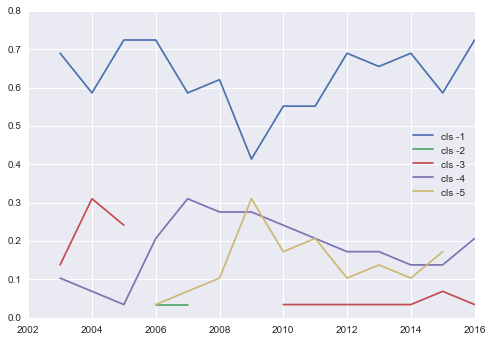

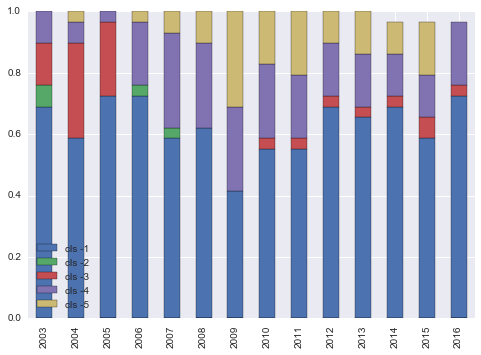

In [27]:
sf = nmf_la_based(sfdf, lanmf)
sf['city'] = 'San Francisco'

In [28]:
sf.head()

class,Year,0,1,2,3,4,city
0,2003,0.689655,0.068966,0.137931,0.103448,NaN,San Francisco
1,2004,0.586207,NaN,0.310345,0.068966,0.034483,San Francisco
2,2005,0.724138,NaN,0.241379,0.034483,NaN,San Francisco
3,2006,0.724138,0.034483,NaN,0.206897,0.034483,San Francisco
4,2007,0.586207,0.034483,NaN,0.310345,0.068966,San Francisco


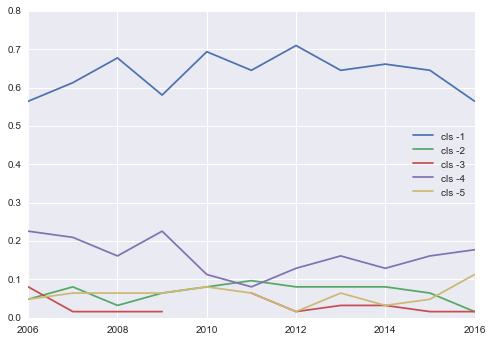

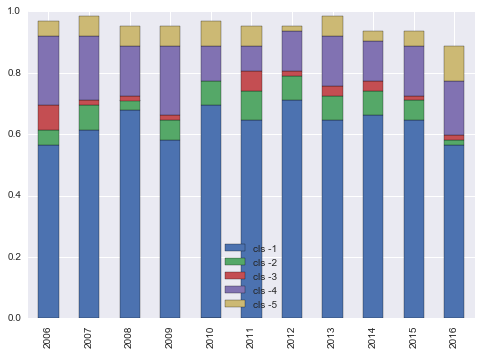

In [29]:
ph = nmf_la_based(phdf, lanmf)
ph['city'] = 'Philadelphia'

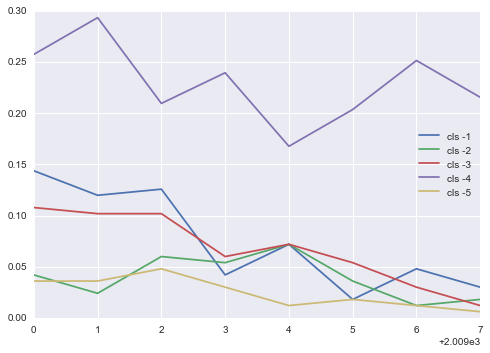

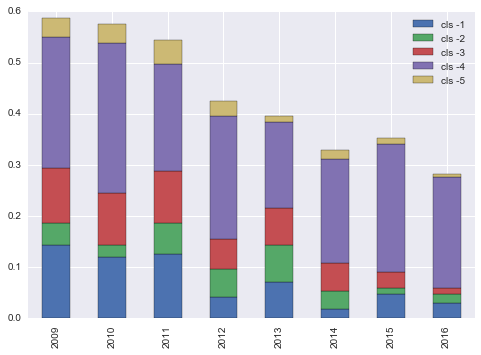

In [30]:
de = nmf_la_based(dedf, lanmf)
de['city'] = 'Detroit'

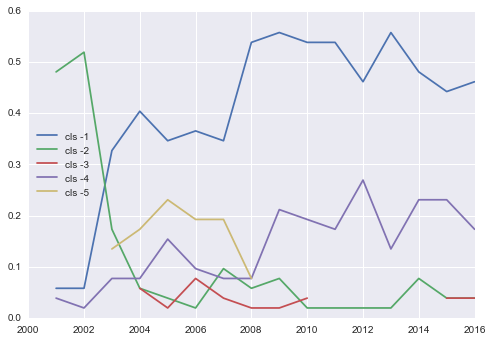

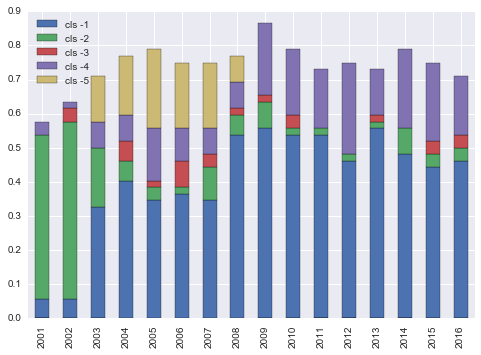

In [31]:
louis = nmf_la_based(louisdf, lanmf)
louis['city'] = 'Louisville'

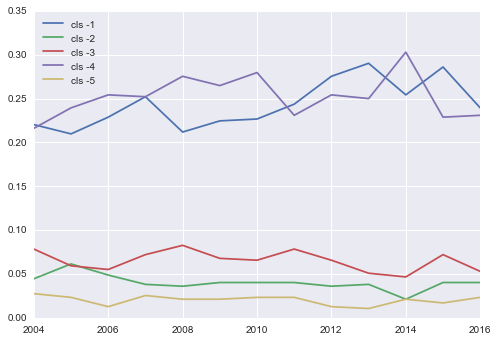

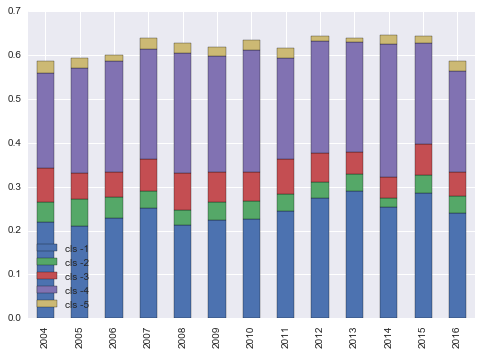

In [32]:
la = nmf_la_based(ladf, lanmf)
la['city'] = 'Los Angeles'

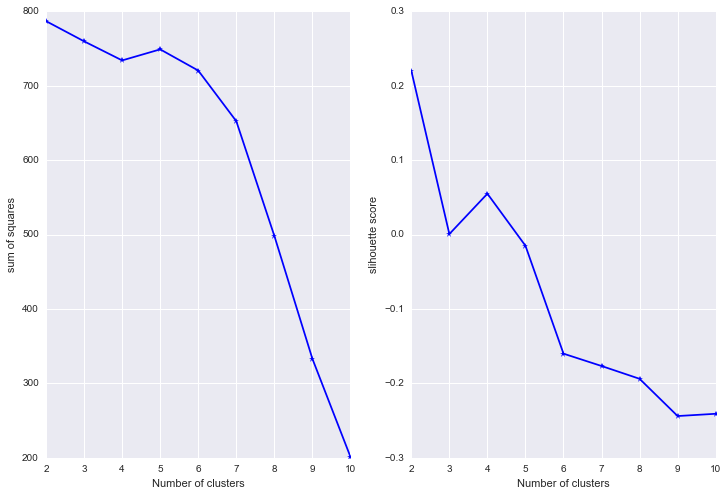

In [33]:
nmf_test(sfdf)

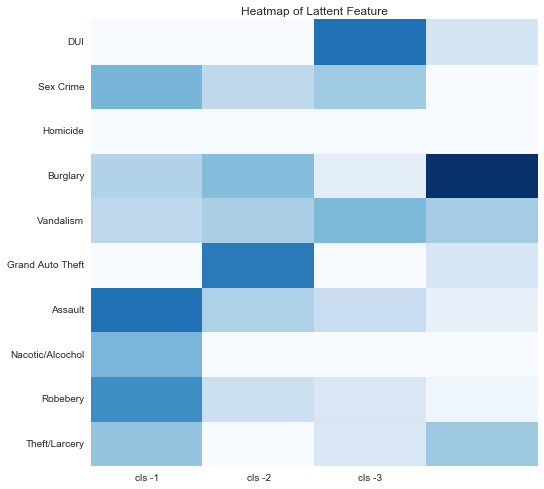

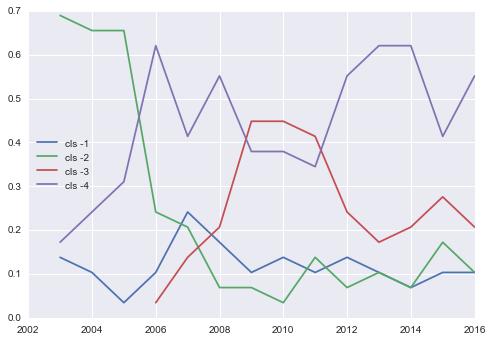

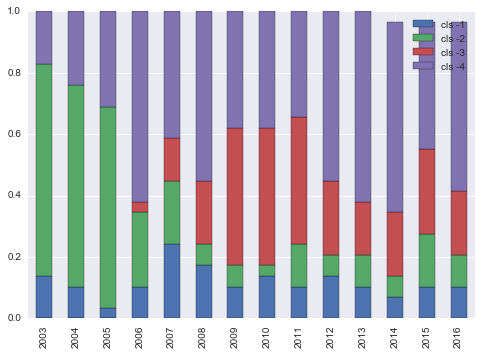

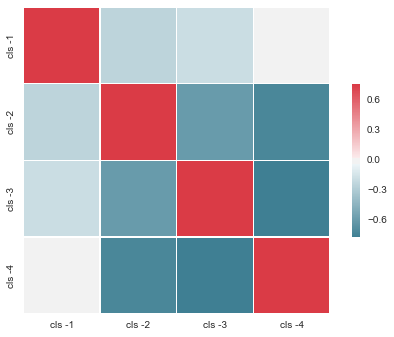

(NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
   n_components=4, nls_max_iter=2000, random_state=None, shuffle=False,
   solver='cd', sparseness=None, tol=0.0001, verbose=0),
      Year  zipcode  class         0         1         2         3
 0    2003    94014      0  0.002720  0.001168  0.000194  0.000000
 1    2003    94102      0  0.392121  0.134221  0.139531  0.148784
 2    2003    94103      1  0.235485  0.306551  0.211661  0.103370
 3    2003    94104      3  0.013321  0.005082  0.002708  0.025919
 4    2003    94105      1  0.011571  0.046916  0.016021  0.040516
 5    2003    94107      1  0.014847  0.224530  0.025908  0.150240
 6    2003    94108      3  0.031392  0.038884  0.000000  0.133864
 7    2003    94109      1  0.109209  0.229326  0.182821  0.162506
 8    2003    94110      1  0.184799  0.496505  0.186852  0.039347
 9    2003    94111      3  0.015531  0.031770  0.000000  0.087504
 10   2003    94112      1  0.079746  0.401045  0.068468  0.00

In [34]:
nmf_pipline(sfdf, 4)

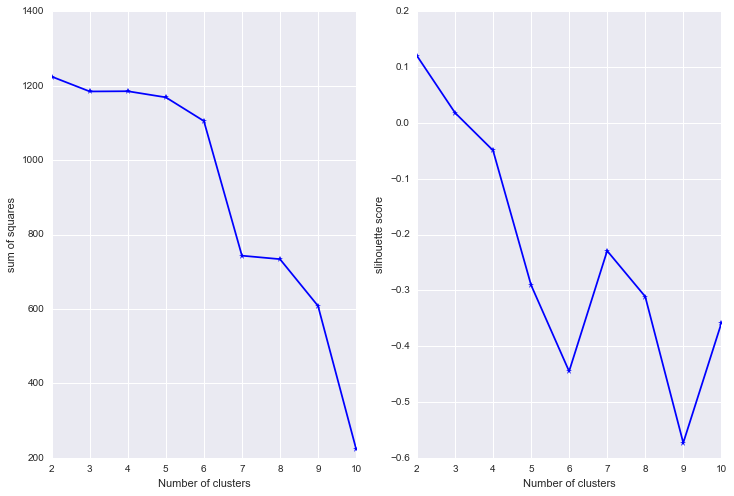

In [35]:
nmf_test(dedf)

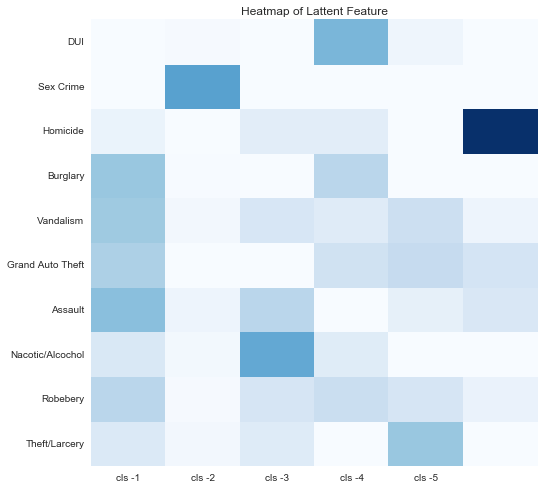

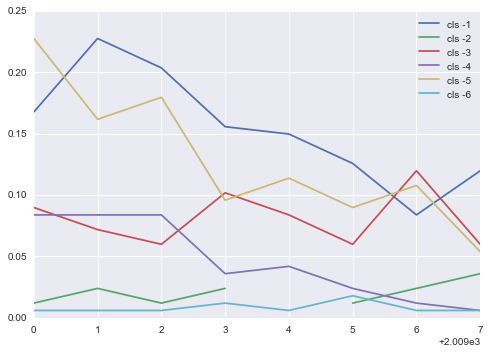

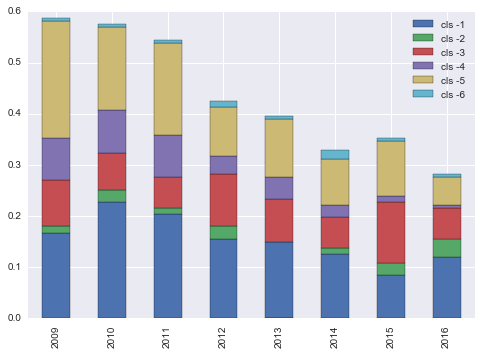

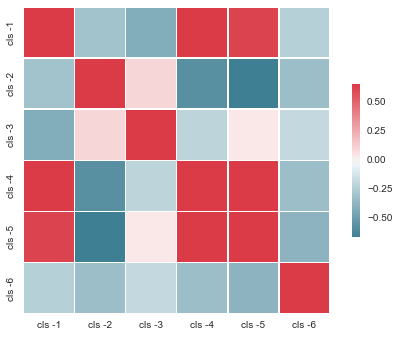

(NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
   n_components=6, nls_max_iter=2000, random_state=None, shuffle=False,
   solver='cd', sparseness=None, tol=0.0001, verbose=0),
      Year zipcode  class         0         1         2             3  \
 0    2009   11433      4  0.000000  0.000000  0.000000  0.000000e+00   
 1    2009   11757      4  0.000000  0.000009  0.000054  0.000000e+00   
 2    2009   12010      0  0.000049  0.000007  0.000032  0.000000e+00   
 3    2009   12061      0  0.000049  0.000007  0.000032  0.000000e+00   
 4    2009   12144      0  0.000049  0.000007  0.000032  0.000000e+00   
 5    2009   14220      0  0.000049  0.000007  0.000032  0.000000e+00   
 6    2009   14521      4  0.000000  0.000000  0.000000  0.000000e+00   
 7    2009   14709      0  0.000049  0.000007  0.000032  0.000000e+00   
 8    2009   15904      0  0.000049  0.000007  0.000032  0.000000e+00   
 9    2009   17111      3  0.000052  0.000000  0.000000  5.465932e-05

In [36]:
nmf_pipline(dedf, 6)

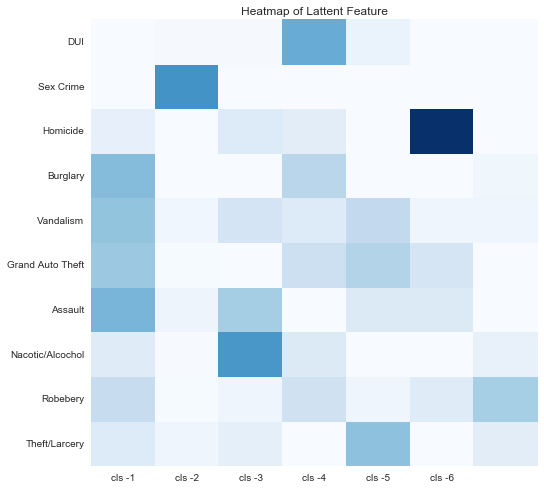

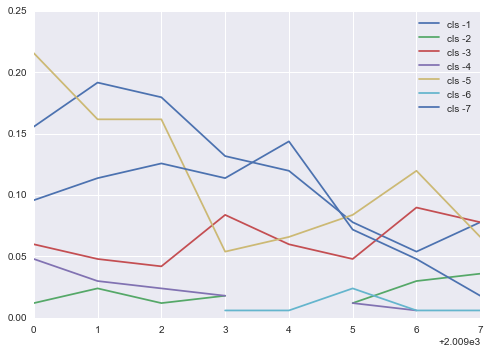

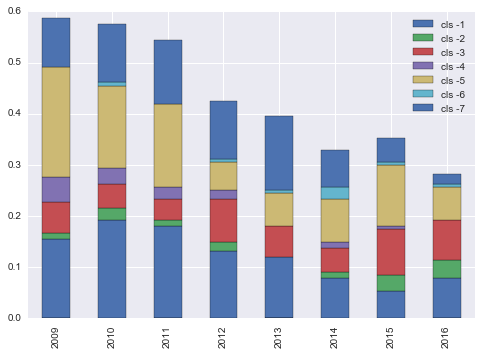

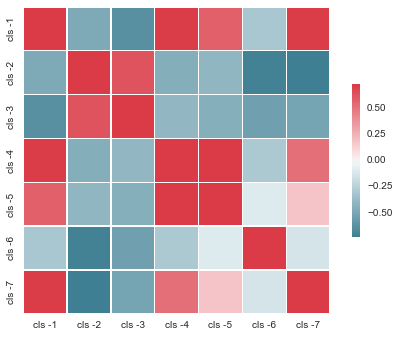

(NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
   n_components=7, nls_max_iter=2000, random_state=None, shuffle=False,
   solver='cd', sparseness=None, tol=0.0001, verbose=0),
      Year zipcode  class         0         1         2             3  \
 0    2009   11433      4  0.000000  0.000000  0.000000  0.000000e+00   
 1    2009   11757      4  0.000000  0.000009  0.000056  0.000000e+00   
 2    2009   12010      0  0.000050  0.000005  0.000046  0.000000e+00   
 3    2009   12061      0  0.000050  0.000005  0.000046  0.000000e+00   
 4    2009   12144      0  0.000050  0.000005  0.000046  0.000000e+00   
 5    2009   14220      0  0.000050  0.000005  0.000046  0.000000e+00   
 6    2009   14521      4  0.000000  0.000000  0.000000  0.000000e+00   
 7    2009   14709      0  0.000050  0.000005  0.000046  0.000000e+00   
 8    2009   15904      0  0.000050  0.000005  0.000046  0.000000e+00   
 9    2009   17111      0  0.000062  0.000000  0.000000  5.089484e-05

In [37]:
nmf_pipline(dedf, 7)

In [38]:
combLst = [sf, de, la, ph, louis]
tot_per = pd.concat(combLst)

In [39]:
tot_per = tot_per.fillna(0)

In [40]:
tot_per

class,Year,0,1,2,3,4,city
0,2003,0.689655,0.068966,0.137931,0.103448,0.000000,San Francisco
1,2004,0.586207,0.000000,0.310345,0.068966,0.034483,San Francisco
2,2005,0.724138,0.000000,0.241379,0.034483,0.000000,San Francisco
3,2006,0.724138,0.034483,0.000000,0.206897,0.034483,San Francisco
4,2007,0.586207,0.034483,0.000000,0.310345,0.068966,San Francisco
5,2008,0.620690,0.000000,0.000000,0.275862,0.103448,San Francisco
6,2009,0.413793,0.000000,0.000000,0.275862,0.310345,San Francisco
7,2010,0.551724,0.000000,0.034483,0.241379,0.172414,San Francisco
8,2011,0.551724,0.000000,0.034483,0.206897,0.206897,San Francisco
9,2012,0.689655,0.000000,0.034483,0.172414,0.103448,San Francisco


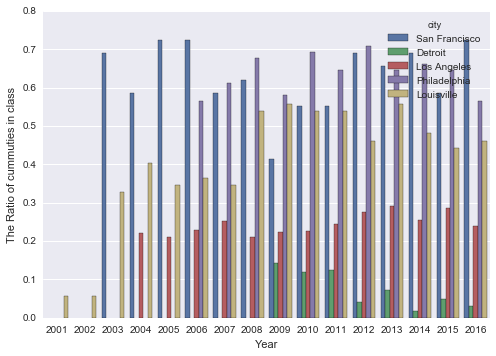

In [41]:
sns.barplot(x='Year', y=0, hue='city', data=tot_per)
plt.ylabel('The Ratio of cummuties in class')

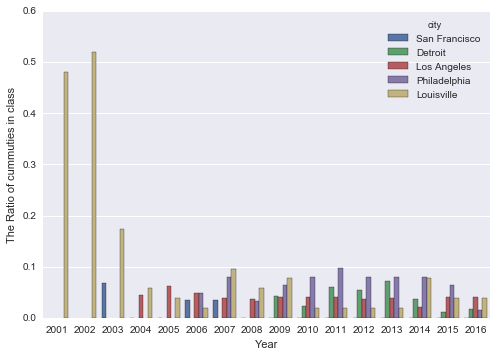

In [42]:
sns.barplot(x='Year', y=1, hue='city', data=tot_per)
plt.ylabel('The Ratio of cummuties in class')

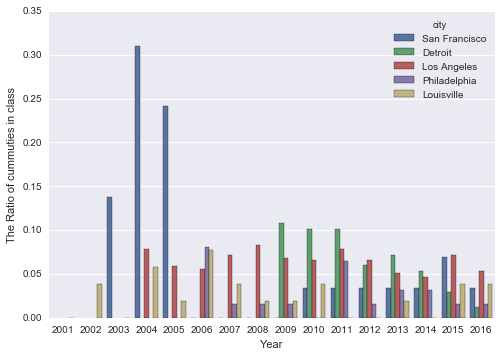

In [43]:
sns.barplot(x='Year', y=2, hue='city', data=tot_per)
plt.ylabel('The Ratio of cummuties in class')

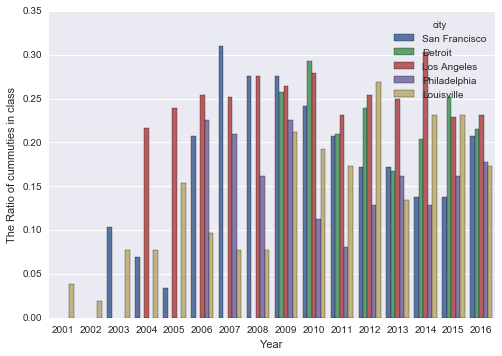

In [44]:
sns.barplot(x='Year', y=3, hue='city', data=tot_per)
plt.ylabel('The Ratio of cummuties in class')

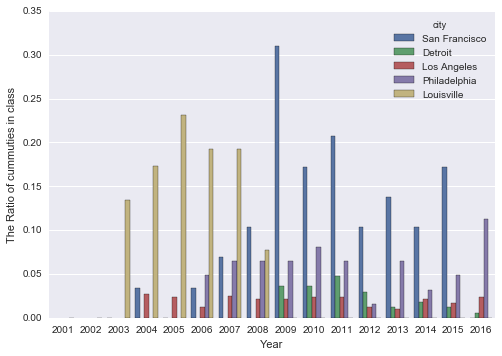

In [45]:
sns.barplot(x='Year', y=4, hue='city', data=tot_per)
plt.ylabel('The Ratio of cummuties in class')

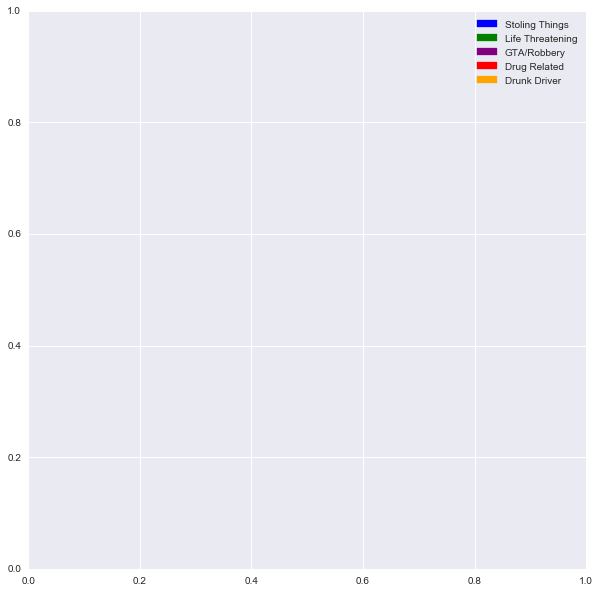

In [46]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
blue_patch = mpatches.Patch(color='blue', label='Stoling Things')
green_patch = mpatches.Patch(color='green', label='Life Threatening')
purple_patch = mpatches.Patch(color='purple', label='GTA/Robbery')
red_patch = mpatches.Patch(color='red', label='Drug Related')
orange_patch = mpatches.Patch(color='orange', label='Drunk Driver')
plt.legend(handles=[blue_patch, green_patch, purple_patch, red_patch, orange_patch])

plt.show()

In [47]:
la

class,Year,0,1,2,3,4,city
0,2004,0.220339,0.044492,0.078390,0.216102,0.027542,Los Angeles
1,2005,0.209746,0.061441,0.059322,0.239407,0.023305,Los Angeles
2,2006,0.228814,0.048729,0.055085,0.254237,0.012712,Los Angeles
3,2007,0.252119,0.038136,0.072034,0.252119,0.025424,Los Angeles
4,2008,0.211864,0.036017,0.082627,0.275424,0.021186,Los Angeles
5,2009,0.224576,0.040254,0.067797,0.264831,0.021186,Los Angeles
6,2010,0.226695,0.040254,0.065678,0.279661,0.023305,Los Angeles
7,2011,0.243644,0.040254,0.078390,0.230932,0.023305,Los Angeles
8,2012,0.275424,0.036017,0.065678,0.254237,0.012712,Los Angeles
9,2013,0.290254,0.038136,0.050847,0.250000,0.010593,Los Angeles
